# 사용자 행동 인식

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv(r'C:\Users\arceu\Desktop\Machine-Learning\data\uci\features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name = df.iloc[:,1].values.tolist()
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [4]:
feature_dup = df.groupby('column_name').count()
print(feature_dup[feature_dup['column_index'] > 1].count())
feature_dup[feature_dup['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [16]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv(r'C:\Users\arceu\Desktop\Machine-Learning\data\uci\features.txt', sep='\s+', header=None, names = ['colmun_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    X_train = pd.read_csv(r'C:\Users\arceu\Desktop\Machine-Learning\data\uci\train\X_train.txt', sep='\s+', header=None, names=feature_name)
    X_test = pd.read_csv(r'C:\Users\arceu\Desktop\Machine-Learning\data\uci\test\X_test.txt', sep='\s+', names=feature_name)
    y_train = pd.read_csv(r'C:\Users\arceu\Desktop\Machine-Learning\data\uci\train\y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv(r'C:\Users\arceu\Desktop\Machine-Learning\data\uci\test\y_test.txt', sep='\s+', header=None, names=['action'])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [17]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [18]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

print(clf.get_params())

0.850356294536817
{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


In [21]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [6, 8, 10, 12, 16, 20, 24]}
grid_cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5)
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8494287268770403
{'max_depth': 8}


#### 추후에 Random Forest를 이용하여 정확도를 더 높일 것

In [24]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847116
1,8,0.849429
2,10,0.847797
3,12,0.846300
4,16,0.846300
5,20,0.845484
6,24,0.846436


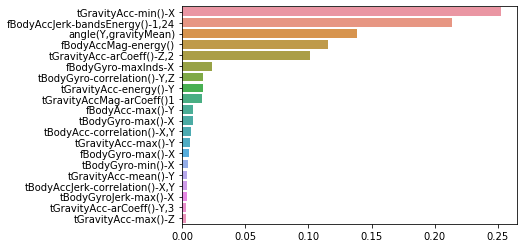

In [29]:
import seaborn as sns 

best_clf = grid_cv.best_estimator_
pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

importances_values = best_clf.feature_importances_
importances = pd.Series(importances_values, index=X_train.columns)
top20 = importances.sort_values(ascending=False)[:20]
sns.barplot(x=top20, y=top20.index)